In [1]:
import io
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
demo = pd.read_csv("/content/drive/MyDrive/롯데 공모전/dataset/LPOINT_BIG_COMP_01_DEMO.csv") #고객 데모 정보
pdde = pd.read_csv("/content/drive/MyDrive/롯데 공모전/dataset/LPOINT_BIG_COMP_02_PDDE.csv") #상품 구매 정보(유통사 상품 구매 내역)
pd_clac = pd.read_csv("/content/drive/MyDrive/롯데 공모전/dataset/LPOINT_BIG_COMP_04_PD_CLAC.csv") #상품 분류 정보(유통사 상품 카테고리 마스터)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
df = pd.merge(pdde, pd_clac,how='outer',on='pd_c')
df = pd.merge(df, demo, how='left', on='cust')
df.head()

,cust,rct_no,chnl_dv,cop_c,br_c,pd_c,de_dt,de_hr,buy_am,buy_ct,pd_nm,clac_hlv_nm,clac_mcls_nm,ma_fem_dv,ages,zon_hlv
0,M430112881,A01000001113,1,A01,A010039,PD0290,20210101,10,15000.0,1,남성티셔츠,남성의류,남성의류상의,여성,50대,Z17
1,M430112881,A01000003148,1,A01,A010039,PD0290,20210101,10,19000.0,1,남성티셔츠,남성의류,남성의류상의,여성,50대,Z17
2,M430112881,A01000003148,1,A01,A010039,PD0290,20210101,10,19000.0,1,남성티셔츠,남성의류,남성의류상의,여성,50대,Z17
3,M430112881,A01000004946,1,A01,A010039,PD0290,20210101,10,19000.0,1,남성티셔츠,남성의류,남성의류상의,여성,50대,Z17
4,M506355556,A01000107137,1,A01,A010032,PD0290,20210101,15,199000.0,1,남성티셔츠,남성의류,남성의류상의,여성,40대,Z17


### 변수 정의

##### 이상치 제거

In [4]:
df=df[df['cust']!='M057015266']
df=df[df['cust']!='M919374790']
print(df.shape)

(4359246, 16)


##### 시간 변수 추가

In [5]:
from datetime import datetime

a = df['de_dt'].astype('str') 
df['de_dt']  = pd.to_datetime(a) #str -> datetime
df['day'] = df['de_dt'].map(lambda x : x.strftime('%A')) #요일
df['month'] = df['de_dt'].dt.month #월
df['day'] = df['de_dt'].dt.day #일

df.head()

,cust,rct_no,chnl_dv,cop_c,br_c,pd_c,de_dt,de_hr,buy_am,buy_ct,pd_nm,clac_hlv_nm,clac_mcls_nm,ma_fem_dv,ages,zon_hlv,day,month
0,M430112881,A01000001113,1,A01,A010039,PD0290,2021-01-01,10,15000.0,1,남성티셔츠,남성의류,남성의류상의,여성,50대,Z17,1,1
1,M430112881,A01000003148,1,A01,A010039,PD0290,2021-01-01,10,19000.0,1,남성티셔츠,남성의류,남성의류상의,여성,50대,Z17,1,1
2,M430112881,A01000003148,1,A01,A010039,PD0290,2021-01-01,10,19000.0,1,남성티셔츠,남성의류,남성의류상의,여성,50대,Z17,1,1
3,M430112881,A01000004946,1,A01,A010039,PD0290,2021-01-01,10,19000.0,1,남성티셔츠,남성의류,남성의류상의,여성,50대,Z17,1,1
4,M506355556,A01000107137,1,A01,A010032,PD0290,2021-01-01,15,199000.0,1,남성티셔츠,남성의류,남성의류상의,여성,40대,Z17,1,1


In [6]:
#계절변수
def wea_fun(x):
  y=''
  if x==3 or x==4 or x==5: y='spr'
  elif x==6 or x==7 or x==8: y='smn'
  elif x==9 or x==10 or x==11: y='atm'
  else: y='win'
  return y

#함수 적용
df["weat"] = df["month"].apply(lambda x: wea_fun(x))

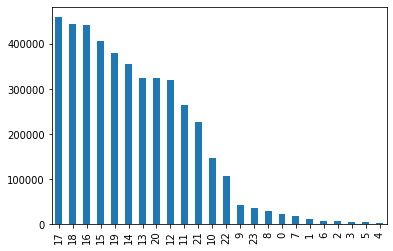

In [26]:
pdde['de_hr'].value_counts().plot(kind='bar')

11 12 13 14 15 16 17 18 19 20 21

1 2 3 4 5  6 7 8 9 10 22 23 24 

In [7]:
def time_fun(x):
  y=''
  if (x>=11 and x <22): y=1
  else: y = 2
  return y

#함수 적용
df["de_hr_1"] = df["de_hr"].apply(lambda x: time_fun(x))

##### 고객의 총 주문 횟수, 고객이 총 주문한 상품 수, 고객이 총 주문한 상품 종류의 수

In [8]:
order1 = df.groupby('cust').sum()['buy_ct'].rename_axis('cust').reset_index(name='total_items') #고객의 총 주문한 상품 수
order2 = df[['rct_no']].value_counts().reset_index(name='one_times_items') #한번에 주문한 상품의 수
order3 = df.groupby('cust')['rct_no'].nunique().reset_index(name='rct_cnt') #구매 횟수

In [9]:
df = pd.merge(df, order1, how='outer',on='cust')
df = pd.merge(df, order2, how='outer',on='rct_no')
df = pd.merge(df, order3, how='outer',on='cust')

df.head()

,cust,rct_no,chnl_dv,cop_c,br_c,pd_c,de_dt,de_hr,buy_am,buy_ct,...,ma_fem_dv,ages,zon_hlv,day,month,weat,de_hr_1,total_items,one_times_items,rct_cnt
0,M430112881,A01000001113,1,A01,A010039,PD0290,2021-01-01,10,15000.0,1,...,여성,50대,Z17,1,1,win,2,580,1,102
1,M430112881,A01000003148,1,A01,A010039,PD0290,2021-01-01,10,19000.0,1,...,여성,50대,Z17,1,1,win,2,580,2,102
2,M430112881,A01000003148,1,A01,A010039,PD0290,2021-01-01,10,19000.0,1,...,여성,50대,Z17,1,1,win,2,580,2,102
3,M430112881,A01000004946,1,A01,A010039,PD0290,2021-01-01,10,19000.0,1,...,여성,50대,Z17,1,1,win,2,580,1,102
4,M430112881,A01000005297,1,A01,A010039,PD1692,2021-01-01,10,9900.0,1,...,여성,50대,Z17,1,1,win,2,580,1,102


##### 재구매 여부

In [10]:
rebuy_df = df.groupby(['cust', 'clac_mcls_nm','de_dt']).sum()['buy_ct'].reset_index(name='buy_cnt') 
rebuy_df = rebuy_df.sort_values(['cust','clac_mcls_nm','de_dt'])
rebuy_df.head()

,cust,clac_mcls_nm,de_dt,buy_cnt
0,M000034966,건면,2021-09-19,1
1,M000034966,과채음료,2021-01-16,1
2,M000034966,국산과일,2021-09-19,2
3,M000034966,기능성음료,2021-08-29,1
4,M000034966,기능성음료,2021-09-19,3


In [11]:
rebuy_df['dt_diff'] = rebuy_df['de_dt'].diff()
rebuy_df.loc[rebuy_df['cust'] != rebuy_df['cust'].shift(),'dt_diff'] = None 
rebuy_df.loc[rebuy_df['clac_mcls_nm'] != rebuy_df['clac_mcls_nm'].shift(),'dt_diff'] = None

In [12]:
rebuy_df['dt_diff'] = rebuy_df['dt_diff'].dt.days
rebuy_df['dt_diff'] = rebuy_df['dt_diff'].fillna(365)

In [13]:
rebuy_df['rebuy'] = 0
rebuy_df.loc[rebuy_df['dt_diff'] <= 31,'rebuy'] = 1

In [14]:
rebuy_df.head()

,cust,clac_mcls_nm,de_dt,buy_cnt,dt_diff,rebuy
0,M000034966,건면,2021-09-19,1,365.0,0
1,M000034966,과채음료,2021-01-16,1,365.0,0
2,M000034966,국산과일,2021-09-19,2,365.0,0
3,M000034966,기능성음료,2021-08-29,1,365.0,0
4,M000034966,기능성음료,2021-09-19,3,21.0,1


In [ ]:
np.unique(rebuy_df['rebuy'],return_counts=True)

(array([0, 1]), array([1869433, 1427769]))

In [15]:
del rebuy_df['buy_cnt']
del rebuy_df['dt_diff']

In [16]:
df = pd.merge(df, rebuy_df, how='outer',on=['cust','clac_mcls_nm','de_dt'])
df.head()

,cust,rct_no,chnl_dv,cop_c,br_c,pd_c,de_dt,de_hr,buy_am,buy_ct,...,ages,zon_hlv,day,month,weat,de_hr_1,total_items,one_times_items,rct_cnt,rebuy
0,M430112881,A01000001113,1,A01,A010039,PD0290,2021-01-01,10,15000.0,1,...,50대,Z17,1,1,win,2,580,1,102,0
1,M430112881,A01000003148,1,A01,A010039,PD0290,2021-01-01,10,19000.0,1,...,50대,Z17,1,1,win,2,580,2,102,0
2,M430112881,A01000003148,1,A01,A010039,PD0290,2021-01-01,10,19000.0,1,...,50대,Z17,1,1,win,2,580,2,102,0
3,M430112881,A01000004946,1,A01,A010039,PD0290,2021-01-01,10,19000.0,1,...,50대,Z17,1,1,win,2,580,1,102,0
4,M430112881,A01000013098,1,A01,A010039,PD0292,2021-01-01,11,19900.0,1,...,50대,Z17,1,1,win,1,580,1,102,0


In [ ]:
np.unique(df['rebuy'],return_counts=True)

(array([0, 1]), array([2435717, 1946026]))

##### old, new, both

In [ ]:
import datetime

# 2021.11 기준으로 이전과 이후로 데이터를 분리
df_year_round = df[df['de_dt'] < '2021-11-01']
df_year_end = df[df['de_dt'] > '2021-11-01']
print(df_year_round.shape)
print(df_year_end.shape)

(3771323, 22)
(601443, 22)


In [ ]:
#11월 이전 구매 데이터
customer_item_round_set = df_year_round.groupby('cust')['clac_mcls_nm'].apply(set)
print(customer_item_round_set)

cust
M000034966    {남성스포츠화, 사탕/캔디, 기능성음료, 조미료류, 잎채소, 분말류, 뿌리채소, 비...
M000136117    {여성의류전신, 남성스포츠화, 캐쥬얼가방, 남성의류하의, 남성의류상의, 남성의류세트...
M000201112    {스낵류, 포장반찬, 냉장간편식, 생수, 용기라면, 봉지라면, 생활서비스, 탄산음료...
M000225114    {스낵류, 사탕/캔디, 기능성음료, 남성의류하의, 남성의류상의, 조미료류, 향수, ...
M000261625    {여성의류상의, 스낵류, 메이크업, 여성의류전신, 여성속옷, 남성스포츠화, 와인, ...
                                    ...                        
M999599111    {스낵류, 일반담배, 열매채소, 유가공품, 국산소고기, 봉지라면, 해조류, 시리얼,...
M999673157                    {남성케어, 보석, 초콜릿, 일반담배, 화장지/티슈, 식당}
M999770689    {냉장음료, 스낵류, 양주, 사탕/캔디, 기능성음료, 향신료, 조미료류, 뿌리채소,...
M999849895    {헤어액세서리, 스낵류, 사탕/캔디, 기능성음료, 유아식, 조미료류, 간편조리, 패...
M999962961    {스낵류, 여성의류전신, 주방세제, 수영/물놀이, 냉동과일, 간편조리, 여성가방, ...
Name: clac_mcls_nm, Length: 26452, dtype: object


In [ ]:
customer_item_dict = {}

for cust, clac_mcls_nm in customer_item_round_set.items():
  customer_item_dict[cust] = {}
  for clac_mcls in clac_mcls_nm:
    customer_item_dict[cust][clac_mcls] = 'old'

print(str(customer_item_dict)[:100]+"...")

{'M000034966': {'남성스포츠화': 'old', '사탕/캔디': 'old', '기능성음료': 'old', '조미료류': 'old', '잎채소': 'old', '분말류':...


In [ ]:
#11월 이후 구매 데이터
customer_item_end_set = df_year_end.groupby('cust')['clac_mcls_nm'].apply(set)
print(customer_item_end_set)

cust
M000034966                              {스낵류, 비스킷류, 남아완구, 애견용품}
M000136117    {여아의류전신, 기타아웃도어/레저, 여성속옷, 남성의류세트, 유아의류전신, 패션액세...
M000201112                                         {비스킷류, 과채음료}
M000225114    {수입과일, 스낵류, 포장반찬, 계란류, 냉장간편식, 초콜릿, 사탕/캔디, 기능성음...
M000261625                                         {푸드코트, 스킨케어}
                                    ...                        
M999599111                                          {일반담배, 차음료}
M999673157        {남성의류아우터, 초콜릿, 일반담배, 햄/소시지, 임대매출, 기타, 식당, 소주}
M999770689         {봉지라면, 초콜릿, 사탕/캔디, 건강관리용품, 인스턴트커피, 기타, 냉장조리}
M999849895                               {냉장간편식, 장류, 소스류, 조미료류}
M999962961    {스낵류, 주방세제, 건과일, 향신료, 건어물, 식용유류, 전통주, 미국산소고기, ...
Name: clac_mcls_nm, Length: 20682, dtype: object


In [ ]:
for cust, clac_mcls_nm in customer_item_end_set.items():
  if cust in customer_item_dict:
    for clac_mcls in clac_mcls_nm:
      if clac_mcls in customer_item_dict[cust]:
        customer_item_dict[cust][clac_mcls] = 'both'
      else:
        customer_item_dict[cust][clac_mcls] = 'new'
  else:
    customer_item_dict[cust] = {}
    for clac_mcls in clac_mcls_nm:
      customer_item_dict[cust][clac_mcls] = 'new'

print(str(customer_item_dict)[:100] + "...")

{'M000034966': {'남성스포츠화': 'old', '사탕/캔디': 'old', '기능성음료': 'old', '조미료류': 'old', '잎채소': 'old', '분말류':...


In [ ]:
from pandas.core import series
col = ['cust','old', 'new', 'both']
df_order_info = pd.DataFrame(columns=col)

for cust in customer_item_dict:
  old, new, both = 0, 0, 0

  for clac_mcls in customer_item_dict[cust]:
    tmp = customer_item_dict[cust][clac_mcls]
    if tmp == 'old':
      old +=1 
    elif tmp == 'new':
      new +=1
    else:
      both += 1
    
  row = [cust, old, new, both]
  series = pd.Series(row, index = col)
  df_order_info = df_order_info.append(series, ignore_index = True)

df_order_info.head()

,cust,old,new,both
0,M000034966,25,3,1
1,M000136117,41,3,4
2,M000201112,14,1,1
3,M000225114,28,2,15
4,M000261625,15,1,1


In [ ]:
print(df_order_info.shape[0])

# old가 1 이상 + new가 1인상인 유저 수 출력
# >> 11월 이후에 기존에 구매한 적 없는 새로운 상품을 구매한 유저
print("old&new: ",df_order_info[(df_order_info['old']>0 ) & (df_order_info['new']>0)].shape[0])

# both가 1 이상인 유저 수 출력
# >> 재구매한 상품이 있는 유저 수
print("both: " , df_order_info[df_order_info['both'] > 0 ].shape[0])

# new가 1 이상인 유저의 수 출력
# >> 11월 이후 새로 구매한 상품이 있는 유저의 수를 의미한다
print("new: ",df_order_info[df_order_info['new'] > 0 ].shape[0])

26913
old&new:  17856
both:  18438
new:  18353


In [ ]:
df = pd.merge(df, df_order_info, how='outer',on=['cust'])

In [ ]:
df.head()

,cust,rct_no,chnl_dv,cop_c,br_c,pd_c,de_dt,de_hr,buy_am,buy_ct,...,zon_hlv,day,month,total_items,one_times_items,rct_cnt,rebuy,old,new,both
0,M430112881,A01000001113,1,A01,A010039,PD0290,2021-01-01,10,15000.0,1,...,Z17,Friday,1,580,1,102,0,58,6,20
1,M430112881,A01000003148,1,A01,A010039,PD0290,2021-01-01,10,19000.0,1,...,Z17,Friday,1,580,2,102,0,58,6,20
2,M430112881,A01000003148,1,A01,A010039,PD0290,2021-01-01,10,19000.0,1,...,Z17,Friday,1,580,2,102,0,58,6,20
3,M430112881,A01000004946,1,A01,A010039,PD0290,2021-01-01,10,19000.0,1,...,Z17,Friday,1,580,1,102,0,58,6,20
4,M430112881,A01000013098,1,A01,A010039,PD0292,2021-01-01,11,19900.0,1,...,Z17,Friday,1,580,1,102,0,58,6,20


##### 총 재구매 횟수, 재구매 비율

In [17]:
rebuy_df = df.groupby(['cust', 'clac_mcls_nm']).sum()['buy_ct'].reset_index(name='rebuy_cnt') 
rebuy_df['rebuy_cnt'] -= 1
rebuy_df = rebuy_df.groupby('cust').sum()['rebuy_cnt'].reset_index(name='rebuy_cnt') 

df = pd.merge(df, rebuy_df, how='outer',on='cust')
df.head()

,cust,rct_no,chnl_dv,cop_c,br_c,pd_c,de_dt,de_hr,buy_am,buy_ct,...,zon_hlv,day,month,weat,de_hr_1,total_items,one_times_items,rct_cnt,rebuy,rebuy_cnt
0,M430112881,A01000001113,1,A01,A010039,PD0290,2021-01-01,10,15000.0,1,...,Z17,1,1,win,2,580,1,102,0,496
1,M430112881,A01000003148,1,A01,A010039,PD0290,2021-01-01,10,19000.0,1,...,Z17,1,1,win,2,580,2,102,0,496
2,M430112881,A01000003148,1,A01,A010039,PD0290,2021-01-01,10,19000.0,1,...,Z17,1,1,win,2,580,2,102,0,496
3,M430112881,A01000004946,1,A01,A010039,PD0290,2021-01-01,10,19000.0,1,...,Z17,1,1,win,2,580,1,102,0,496
4,M430112881,A01000013098,1,A01,A010039,PD0292,2021-01-01,11,19900.0,1,...,Z17,1,1,win,1,580,1,102,0,496


In [18]:
df['rebuy_ration'] = df['rebuy_cnt']/df['total_items']*100 # 재구매 비율

##### 상품 구매 간격

In [19]:
df = df.sort_values(['cust','de_dt'])
df['dt_diff'] = df['de_dt'].diff()
df.loc[df['cust'] != df['cust'].shift(),'dt_diff'] = None

In [20]:
df['dt_diff'] = df['dt_diff'].dt.days

In [ ]:
df.to_csv('lotto_df.csv') #csv파일로 생성

In [22]:
#성별 인코딩: 여1, 남0을 사용합니다
df['ma_fem_dv']=df.ma_fem_dv.apply(lambda x: 1 if x=='여성' else 0)

In [23]:
#연령: 연령대의 대표값으로 나타내기 위해, 연령대+ 5를 사용합니다
df['ages']=df.ages.apply(lambda x: int(x[:-1])+5)

In [24]:
#주말이 아닌 공휴일 변수
#혜린이 코드에서 조금 변경사항 있어욥 
holi=[]
holiday=['0101','0211','0212','0301','0505','0519','0816','0920','0921','0922','1004','1011']
for h in holiday:
  holi.append('2021'+h)

c = pd.to_datetime(holi)
df['holi']=df.de_dt.apply(lambda x: 1 if x in c else 0)

In [25]:
#요일 변수
datedict={0:'mon',1:'tue',2:'wed',3:'thu',4:'fri',5:'sat',6:'sun'}
df["weekday"] = df["de_dt"].apply(lambda x: datedict[x.weekday()])
df['weekday']=df.weekday.apply(lambda x: 1 if x=='sat' or x=='sun' else 0)

In [26]:
#거주지역 변수 설정
df['zon_hlv']=df.zon_hlv.apply(lambda x: 1 if x=='Z17' or x=='Z10' else 0)

In [28]:
buy_df = df.groupby(['cust', 'clac_mcls_nm']).mean()['buy_am'].reset_index(name='total_am') 
df = pd.merge(df, buy_df, how='outer',on=['cust','clac_mcls_nm'])

In [30]:
df =  df.drop(['rct_no', 'chnl_dv', 'cop_c', 'br_c', 'pd_c', 'de_dt', 'de_hr', 'pd_nm', 'clac_hlv_nm', 'day', 'month','rct_cnt'], axis=1)
df.head()

,cust,buy_am,buy_ct,clac_mcls_nm,ma_fem_dv,ages,zon_hlv,weat,de_hr_1,total_items,one_times_items,rebuy,rebuy_cnt,rebuy_ration,dt_diff,holi,weekday,total_am
0,M000034966,100.0,1,스포츠잡화,1,45,0,win,1,63,3,0,34,53.968254,NaN,0,1,100.0
1,M000034966,59000.0,1,남성스포츠화,1,45,0,win,1,63,3,0,34,53.968254,0.0,0,1,39000.0
2,M000034966,19000.0,1,남성스포츠화,1,45,0,win,1,63,3,0,34,53.968254,0.0,0,1,39000.0
3,M000034966,62100.0,1,여성스포츠화,1,45,0,win,1,63,1,0,34,53.968254,0.0,0,1,62100.0
4,M000034966,1200.0,1,과채음료,1,45,0,win,1,63,2,0,34,53.968254,0.0,0,1,1200.0


In [45]:
df.columns

Index(['cust', 'rct_no', 'chnl_dv', 'cop_c', 'br_c', 'pd_c', 'de_dt', 'de_hr',
       'buy_am', 'buy_ct', 'pd_nm', 'clac_hlv_nm', 'clac_mcls_nm', 'ma_fem_dv',
       'ages', 'zon_hlv', 'day', 'month', 'weat', 'de_hr_1', 'holi', 'weekday',
       'total_am', 'rebuy', 'one_times_items'],
      dtype='object')

### 모델링

In [18]:
df = pd.read_csv("/content/drive/MyDrive/롯데 공모전/dataset/final_df.csv")

In [19]:
df.head()

,cust,clac_mcls_nm,de_hr_1,buy_am,buy_ct,ma_fem_dv,ages,weat,zon_hlv,weekday,holi,one_times_items,rebuy_ration,rebuy_cnt,de_diff,total_am,rebuy
0,M000034966,스포츠잡화,a_7,100.0,1,1,45,win,0,1,0,3,53.968254,34,365.0,100.0,0
1,M000034966,남성스포츠화,a_7,59000.0,1,1,45,win,0,1,0,3,53.968254,34,0.0,39000.0,0
2,M000034966,남성스포츠화,a_7,19000.0,1,1,45,win,0,1,0,3,53.968254,34,0.0,39000.0,0
3,M000034966,여성스포츠화,a_7,62100.0,1,1,45,win,0,1,0,1,53.968254,34,0.0,62100.0,0
4,M000034966,과채음료,a_9,1200.0,1,1,45,win,0,1,0,2,53.968254,34,0.0,1200.0,0


In [20]:
df = df.set_index(['cust', 'clac_mcls_nm'])
# df =  df.drop([ 'total_items'], axis=1)
df.head()

de_hr_1   buy_am  buy_ct  ma_fem_dv  ages weat  \
cust       clac_mcls_nm                                                  
M000034966 스포츠잡화            a_7    100.0       1          1    45  win   
           남성스포츠화           a_7  59000.0       1          1    45  win   
           남성스포츠화           a_7  19000.0       1          1    45  win   
           여성스포츠화           a_7  62100.0       1          1    45  win   
           과채음료             a_9   1200.0       1          1    45  win   

                         zon_hlv  weekday  holi  one_times_items  \
cust       clac_mcls_nm                                            
M000034966 스포츠잡화               0        1     0                3   
           남성스포츠화              0        1     0                3   
           남성스포츠화              0        1     0                3   
           여성스포츠화              0        1     0                1   
           과채음료                0        1     0                2   

                         rebuy_ration  rebuy_cnt  de_diff  total_am  rebuy  
cust       clac_mcls_nm                                                     
M000034966 스포츠잡화            53.968254         34    365.0     100.0      0  
           남성스포츠화           53.968254         34      0.0   39000.0      0  
           남성스포츠화           53.968254         34      0.0   39000.0      0  
           여성스포츠화           53.968254         34      0.0   62100.0      0  
           과채음료             53.968254         34      0.0    1200.0      0

#### 결측치 제거

In [6]:
df['dt_diff'] = df['dt_diff'].fillna(365)

In [21]:
df.isna().sum()

de_hr_1            0
buy_am             0
buy_ct             0
ma_fem_dv          0
ages               0
weat               0
zon_hlv            0
weekday            0
holi               0
one_times_items    0
rebuy_ration       0
rebuy_cnt          0
de_diff            0
total_am           0
rebuy              0
dtype: int64

#### 인코딩

In [ ]:
df['zon_hlv']=df['zon_hlv'].apply(lambda x: 1 if x=='Z17' or x=='Z10' else 0)

In [22]:
de_hr_list = df['de_hr_1'].value_counts().index[::-1]
de_hr_dict = dict(zip(de_hr_list, range(0,10)))
df = df.replace({'de_hr_1': de_hr_dict})

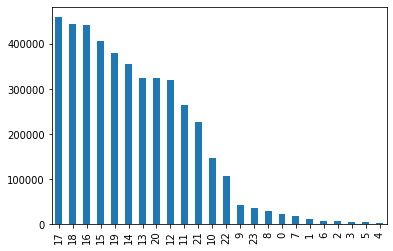

In [21]:
pdde['de_hr'].value_counts().plot(kind='bar')

11 12 13 14 15 16 17 18 19 20 21

1 2 3 4 5  6 7 8 9 10 22 23 24 

In [ ]:
def time_fun(x):
  y=''
  if a>=2 and x<5: y='a_1'  
  elif (x>=5 and x<8): y='a_2' 
  elif (x>=8 and x<10): y='a_3' 
  elif (x>=10 and x<12): y='a_4' 
  elif (x>=12 and x<14): y='a_5'
  elif (x>=14 and x<16): y='a_6'
  elif (x>=16 and x<19): y='a_7'
  elif (x>=19 and x<21): y='a_8'
  elif (x>=21 and x<23): y='a_9'
  else: y='a_10'
  return y

#함수 적용
df["de_hr_1"] = df["de_hr"].apply(lambda x: time_fun(x))

In [20]:
df['de_hr_1'].unique()

array(['a_7', 'a_9', 'a_5', 'a_6', 'a_8', 'a_4', 'a_3', 'a_10', 'a_1',
       'a_2'], dtype=object)

In [ ]:
ages_list = df['ages'].value_counts().index[::-1]
ages_dict = dict(zip(ages_list, range(0,17)))
df = df.replace({'ages': ages_dict})

In [ ]:
ma_fem_list = df['ma_fem_dv'].value_counts().index[::-1]
ma_fem_dict = dict(zip(ma_fem_list, range(0,2)))
df = df.replace({'ma_fem_dv': ma_fem_dict})

In [23]:
weat_list = df['weat'].value_counts().index[::-1]
weat_dict = dict(zip(weat_list, range(0,4)))
df = df.replace({'weat': weat_dict})

In [24]:
df.head()

de_hr_1   buy_am  buy_ct  ma_fem_dv  ages  weat  \
cust       clac_mcls_nm                                                    
M000034966 스포츠잡화               9    100.0       1          1    45     2   
           남성스포츠화              9  59000.0       1          1    45     2   
           남성스포츠화              9  19000.0       1          1    45     2   
           여성스포츠화              9  62100.0       1          1    45     2   
           과채음료                4   1200.0       1          1    45     2   

                         zon_hlv  weekday  holi  one_times_items  \
cust       clac_mcls_nm                                            
M000034966 스포츠잡화               0        1     0                3   
           남성스포츠화              0        1     0                3   
           남성스포츠화              0        1     0                3   
           여성스포츠화              0        1     0                1   
           과채음료                0        1     0                2   

                         rebuy_ration  rebuy_cnt  de_diff  total_am  rebuy  
cust       clac_mcls_nm                                                     
M000034966 스포츠잡화            53.968254         34    365.0     100.0      0  
           남성스포츠화           53.968254         34      0.0   39000.0      0  
           남성스포츠화           53.968254         34      0.0   39000.0      0  
           여성스포츠화           53.968254         34      0.0   62100.0      0  
           과채음료             53.968254         34      0.0    1200.0      0

In [ ]:
df.corr().loc["rebuy"].abs().sort_values(ascending=False)

rebuy              1.000000
rebuy_ration       0.322548
rebuy_cnt          0.277469
de_diff            0.085342
weekday            0.054675
de_hr_1            0.045358
ages               0.039359
total_am           0.030657
zon_hlv            0.028393
holi               0.025971
buy_am             0.025635
ma_fem_dv          0.019556
one_times_items    0.008404
weat               0.007940
buy_ct             0.007766
Name: rebuy, dtype: float64

In [35]:
df.to_csv('lotto_df.csv') #csv파일로 생성

#### 모델링

In [25]:
X = df.drop(['rebuy'], axis=1)
y = df['rebuy']

In [9]:
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [10]:
import warnings
warnings.filterwarnings('ignore')

In [26]:
X_train, X_test, y_train, y_test=train_test_split(X,y,test_size=0.4,random_state=2)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(2615547, 14)
(2615547,)
(1743699, 14)
(1743699,)


In [ ]:
! pip install catboost
! pip install ngboost

In [13]:
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.linear_model import ElasticNet, Lasso, LinearRegression
from sklearn.preprocessing import RobustScaler
import statsmodels.api as sm
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from ngboost import NGBRegressor

In [14]:
from sklearn.metrics import make_scorer

def NMAE(true, pred):
    mae = np.mean(np.abs(true - pred))
    score = mae / np.mean(np.abs(true))
    return score

nmae_score = make_scorer(NMAE, greater_is_better=False)

##### 모델 탐색


- lr

In [27]:
lr=LinearRegression()
lr.fit(X_train,y_train)
y_lr=lr.predict(X_test)
score_lr=NMAE(y_test, y_lr)
print(score_lr)

0.9908761860939492


- rg

In [28]:
rg=Ridge()
rg.fit(X_train,y_train)
y_rg=rg.predict(X_test)
score_rg=NMAE(y_test, y_rg)
print(score_rg)

0.9908761960219227


- xgb

In [29]:
xgb=XGBRegressor(random_state = 42, learning_rate=0.05, n_estimators=20)
xgb.fit(X_train,y_train)
y_xgb=xgb.predict(X_test)
score_xgb=NMAE(y_test, y_xgb)
print(score_xgb)

[02:48:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
1.0316192485002538


- gbr

In [30]:
gbr=GradientBoostingRegressor(random_state = 42, max_depth = 4, learning_rate=0.01, loss='huber', n_estimators=50)
gbr.fit(X_train,y_train)
y_gbr=gbr.predict(X_test)
score_gbr=NMAE(y_test, y_gbr)
print(score_gbr)

0.9800517449268821


- cat

In [31]:
cat_reg=CatBoostRegressor(depth = 4, random_state = 42, loss_function = 'MAE', n_estimators = 100, learning_rate = 0.03, verbose = 0)
cat_reg.fit(X_train,y_train)
y_train_pred = cat_reg.predict(X_train)
y_test_pred = cat_reg.predict(X_test)
score_cat=NMAE(y_test, y_test_pred)
print(score_cat)

0.81047300041396


In [15]:
cat_reg=CatBoostRegressor(depth = 4, random_state = 42, loss_function = 'MAE', n_estimators = 100, learning_rate = 0.03, verbose = 0)
cat_reg.fit(X_train,y_train)
y_train_pred = cat_reg.predict(X_train)
y_test_pred = cat_reg.predict(X_test)
score_cat=NMAE(y_test, y_test_pred)
print(score_cat)

0.8124173987502696


In [ ]:
cat_reg=CatBoostRegressor(depth = 4, random_state = 42, loss_function = 'MAE', n_estimators = 100, learning_rate = 0.01, verbose = 0)
cat_reg.fit(X_train,y_train)
y_train_pred = cat_reg.predict(X_train)
y_test_pred = cat_reg.predict(X_test)
score_cat=NMAE(y_test, y_test_pred)
print(score_cat)

0.8743559781335112


In [ ]:
cat_reg=CatBoostRegressor(depth = 16, random_state = 42, loss_function = 'MAE', n_estimators = 100, learning_rate = 0.3, verbose = 0)
cat_reg.fit(X_train,y_train)
y_train_pred = cat_reg.predict(X_train)
y_test_pred = cat_reg.predict(X_test)
score_cat=NMAE(y_test, y_test_pred)
print(score_cat)

- lgb

In [34]:
lgb=LGBMRegressor(random_state = 42, learning_rate=0.01, n_estimators=50)
lgb.fit(X_train,y_train)
y_lgb=lgb.predict(X_test)
score_lgb=NMAE(y_test, y_lgb)
print(score_lgb)

1.050470415863544


- ngb

In [ ]:
ngb = NGBRegressor(random_state = 42, n_estimators = 50, verbose = 0, learning_rate = 0.01)
ngb.fit(X_train,y_train)
y_ngb = ngb.predict(X_test)
score_ngb=NMAE(y_test, y_ngb)
print(score_ngb)

- ada

In [33]:
ada=AdaBoostRegressor(random_state = 42, learning_rate=0.03, n_estimators=25)
ada.fit(X_train,y_train)
y_ada = ada.predict(X_test)
score_ada=NMAE(y_test, y_ada)
print(score_ada)

0.9838832141340442


- hgb

In [32]:
hgb=HistGradientBoostingRegressor(random_state=42, scoring=nmae_score, learning_rate=0.01)
hgb.fit(X_train, y_train)
y_hgb = hgb.predict(X_test)
score_hgb = NMAE(y_test, y_hgb)
print(score_hgb)

1.009584872274517


In [36]:
print("LinearRegression: " , score_lr)
print("Ridge: ", score_rg)
print("XGBRegressor: ", score_xgb)
print("GradientBoostingRegressor: ", score_gbr)
print("CatBoostRegressor: ", score_cat)
print("LGBMRegresso: ", score_lgb)
# print("NGBMRegresso: ", score_ngb)
print("AdaBoostRegressor: ", score_ada)
print("HistGradientBoostingRegressor: ", score_hgb)

LinearRegression:  0.9908761860939492
Ridge:  0.9908761960219227
XGBRegressor:  1.0316192485002538
GradientBoostingRegressor:  0.9800517449268821
CatBoostRegressor:  0.81047300041396
LGBMRegresso:  1.050470415863544
AdaBoostRegressor:  0.9838832141340442
HistGradientBoostingRegressor:  1.009584872274517


LinearRegression + Ridge + GradientBoostingRegressor + CatBoostRegressor

#### catboost 

In [16]:
y_test_preds = [1 if x >= 0.5 else 0 for x in y_test_pred]
print(y_test_preds[:10])

y_train_preds = [1 if x >= 0.5 else 0 for x in y_train_pred]
print(y_train_preds[:10])

[0, 0, 0, 0, 0, 1, 1, 1, 1, 0]
[1, 1, 1, 1, 1, 0, 1, 0, 1, 0]


In [17]:
print('훈련 MSE: %.3f, 테스트 MSE: %.3f' % (
      mean_squared_error(y_train, y_train_pred),
      mean_squared_error(y_test, y_test_pred)))
print('훈련 R^2: %.3f, 테스트 R^2: %.3f' % (
      r2_score(y_train, y_train_pred),
      r2_score(y_test, y_test_pred)))

print('훈련 정확도: %.3f, 테스트 정확도: %.3f' % (
     accuracy_score(y_train, y_train_preds),
      accuracy_score(y_test, y_test_preds)))

훈련 MSE: 0.287, 테스트 MSE: 0.287
훈련 R^2: -0.164, 테스트 R^2: -0.163
훈련 정확도: 0.648, 테스트 정확도: 0.648


In [ ]:
! pip install optuna

In [ ]:
import optuna
from optuna.samplers import TPESampler
from sklearn.metrics import log_loss

In [ ]:
def objective(trial):
  param = {
      "random_state":42,
      'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
      'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),
      "n_estimators":trial.suggest_int("n_estimators", 1000, 10000),
      "max_depth":trial.suggest_int("max_depth", 4, 16),
      'random_strength' :trial.suggest_int('random_strength', 0, 100),
      "colsample_bylevel":trial.suggest_float("colsample_bylevel", 0.4, 1.0),
      "l2_leaf_reg":trial.suggest_float("l2_leaf_reg",1e-8,3e-5),
      "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
      "max_bin": trial.suggest_int("max_bin", 200, 500),
      'od_type': trial.suggest_categorical('od_type', ['IncToDec', 'Iter']),
  }

  X_train, X_valid, y_train, y_valid = train_test_split(X,y,test_size=0.4)
  
  cat_features =[0,1,2,5,6,7,8,15,18]
  cat = CatBoostRegressor(**param)
  cat.fit(X_train, y_train,
          eval_set=[(X_train, y_train), (X_valid,y_valid)],
          early_stopping_rounds=35,
          verbose=100)
  cat_pred = cat.predict_proba(X_valid)
  log_score = log_loss(y_valid, cat_pred)

  return log_score

In [ ]:
sampler = TPESampler(seed=42)
study = optuna.create_study(
    study_name = 'cat_parameter_opt',
    direction = 'minimize',
    sampler = sampler,
)
study.optimize(objective, n_trials=10)
print("Best Score:",study.best_value)
print("Best trial",study.best_trial.params)

https://www.dacon.io/codeshare/2750

#### 앙상블

In [38]:
kf = KFold(n_splits = 10, random_state = 42, shuffle = True)

In [39]:
target = df['rebuy']

In [ ]:
# cat
cat_pred = np.zeros(target.shape[0])
cat_val = []
for n, (tr_idx, val_idx) in enumerate(kf.split(X, y)) :
    tr_x, tr_y = X.iloc[tr_idx], y.iloc[tr_idx]
    val_x, val_y = X.iloc[val_idx], np.expm1(y.iloc[val_idx])
    
    tr_data = Pool(data = tr_x, label = tr_y)
    val_data = Pool(data = val_x, label = val_y)
    
    cat = CatBoostRegressor(depth = 4, random_state = 42, loss_function = 'MAE', n_estimators = 100, learning_rate = 0.03, verbose = 0)
    cat.fit(tr_data, eval_set = val_data, early_stopping_rounds = 750, verbose = 1000)
    
    val_pred = np.expm1(cat.predict(val_x))
    val_nmae = NMAE(val_y, val_pred)
    cat_val.append(val_nmae)
    print(f'{n + 1} FOLD NMAE = {val_nmae}')
    
    target_data = Pool(data = target, label = None)
    fold_pred = cat.predict(target) / 10
    cat_pred += fold_pred
print(f'10FOLD Mean of NMAE = {np.mean(cat_val)}')

0:	learn: 0.4388562	test: 0.7556179	best: 0.7556179 (0)	total: 1.3s	remaining: 2m 9s


In [ ]:
print(np.mean(cat_val))

0.7464946690008415


#### 기본 로지스틱 회귀

In [ ]:
LR = LogisticRegression(C=1e2, multi_class='ovr', random_state=1, max_iter=200)

LR.fit(X_train, y_train)
y_train_pred = LR.predict(X_train)
y_test_pred = LR.predict(X_test)

print('훈련 MSE: %.3f, 테스트 MSE: %.3f' % (
      mean_squared_error(y_train, y_train_pred),
      mean_squared_error(y_test, y_test_pred)))
print('훈련 R^2: %.3f, 테스트 R^2: %.3f' % (
      r2_score(y_train, y_train_pred),
      r2_score(y_test, y_test_pred)))

print('훈련 정확도: %.3f, 테스트 정확도: %.3f' % (
     accuracy_score(y_train, y_train_pred),
      accuracy_score(y_test, y_test_pred)))

훈련 MSE: 0.354, 테스트 MSE: 0.354
훈련 R^2: -0.432, 테스트 R^2: -0.433
훈련 정확도: 0.646, 테스트 정확도: 0.646
